In [1]:
import torch
import torch.nn as nn
#from pyhessian import hessian
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from torchsummary import summary
import torch.nn.functional as F
import scipy as sp

colors = ['blue', 'darkorange','green','red','purple','brown','pink', 'gray', 'olive', 'cyan' , 'darkgreen', 'indigo', 'maroon', 'navy']
epochs = 200
n_tasks = 3
L = 0
gamma0 = 2
widths = [4096]
device = 'mps'
gen = torch.Generator(device=device)
gen.manual_seed(1234)
batch = 25
eta = 0.1
Synt = True
relu = False
perc = 0.7

class MLP(nn.Module):
            def __init__(self, w, L, param, gam):
                super(MLP, self).__init__()
                self.w = w
                if param =='ntk':
                    self.gamma = gam
                    self.in_scale = 784**0.5
                    self.out_scale = self.w**0.5*self.gamma
                elif param == 'mup': 
                     self.gamma = gam*self.w**0.5
                     self.in_scale = 784**0.5
                     self.out_scale = self.w**0.5*self.gamma
                elif param == 'sp':
                     self.gamma = 1
                     self.in_scale = 1
                     self.out_scale = 1

                self.fc1 = nn.Linear(784, self.w, bias=False)
                self.fc2 = nn.Linear(self.w, 1, bias=False)
                self.relu = nn.ReLU()
                self.L = L

            def forward(self, x):
                h1 = self.fc1(x)/self.in_scale
                if relu:
                    h1act = self.relu(h1)
                else:
                    h1act = h1
                z = ( torch.sum(self.fc2.weight.T, dim=1)).detach().clone()
                h2 = self.fc2(h1act)/self.out_scale
            
                return h2, h1.detach().clone(), z

@torch.no_grad()
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.normal_()

def permut_row(x, perm):
            return x[perm]

        # ---------------------- START DATA -------------------------
if not Synt:
    tasks = []
    tasks_test = []
    for dig1, dig2 in zip([0],[1]):
        data = pd.read_csv('~/data/MNIST/mnist_train.csv')
        test = pd.read_csv('~/data/MNIST/mnist_test.csv')
        data = data[data['label'].isin([dig1, dig2])]
        test = test[test['label'].isin([dig1, dig2])]

        X = torch.tensor(data.drop('label', axis = 1).to_numpy(), device=device)/255
        X_test = torch.tensor(test.drop('label', axis = 1).to_numpy(), device=device)/255
        X = X[:batch]

        Y_temp = torch.tensor(data['label'].to_numpy(), device=device)
        Y = torch.tensor([[y*1.0-torch.min(Y_temp)] for y in Y_temp], device=device)
        Y = Y[:batch]
        _ , indeces = torch.sort(Y_temp[:batch])
        Y = Y[indeces]
        X = X[indeces]

        Y_temp = torch.tensor(test['label'].to_numpy(), device=device)
        Y_test = torch.tensor([[y*1.0 - torch.min(Y_temp)] for y in Y_temp], device=device)

        #tasks.append(X)
        #tasks_test.append(X_test)


    #lim = int((784-int(X.shape[1]*perc))/2)

    #for _ in range(n_tasks+1):
    #        par_perm = np.append(np.append(np.arange(0,lim,1),np.random.permutation(int(X.shape[1]*perc))+lim), np.arange(int(X.shape[1]*perc)+lim,784,1))
    #        #perm = np.random.permutation(X.shape[1])
    #        tasks.append( torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X.cpu(), perm=par_perm)).to(device) )
    #        tasks_test.append(torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X_test.cpu(), perm=par_perm)).to(device))

    lim = int(X.shape[1]*perc)

    for _ in range(n_tasks+1):
            par_perm = np.append(np.random.permutation(lim),np.arange(lim,X.shape[1],1))
            #perm = np.random.permutation(X.shape[1])
            tasks.append( torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X.cpu(), perm=par_perm)).to(device) )
            tasks_test.append(torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X_test.cpu(), perm=par_perm)).to(device))
    
else:
    tasks = []
    tasks_test = []
    P = 25
    D = 784
    X = torch.distributions.MultivariateNormal(torch.zeros(D), torch.eye(D)).sample((P,)).to(device)
    X_test = torch.distributions.MultivariateNormal(torch.zeros(D), torch.eye(D)).sample((P,)).to(device)
    Y = torch.hstack((torch.zeros((int(P/2)+1,)),torch.ones((int(P/2),)))).view(25,1).to(device)
    Y_test = Y.clone()

    lim = int((784-int(X.shape[1]*perc))/2)

    for _ in range(n_tasks+1):
            par_perm = np.append(np.append(np.arange(0,lim,1),np.random.permutation(int(X.shape[1]*perc))+lim), np.arange(int(X.shape[1]*perc)+lim,784,1))
            #perm = np.random.permutation(X.shape[1])
            tasks.append( torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X.cpu(), perm=par_perm)).to(device) )
            tasks_test.append(torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X_test.cpu(), perm=par_perm)).to(device))

    

In [2]:
def plot_dist(vecs, all= True, log= True):
    fig = plt.figure(figsize=(16,10))
    for i,vec in enumerate(vecs):
        counts, bins = torch.histogram(vec.view(-1), bins=200)
        if i == 0: 
            plt.plot(bins[:-1], counts/(torch.sum(counts)*(bins[1]-bins[0])), linestyle = '-.', color='black', label = 'Theory')
        else:
            plt.plot(bins[:-1], counts/(torch.sum(counts)*(bins[1]-bins[0])), color='purple', alpha=0.4, label = 'Experimental', linewidth=3)
            
            
        if not all:
            if log:
                plt.yscale('log')
            plt.grid()
            plt.xlabel('$x$')
            plt.ylabel('$p(x)$')
            plt.show()
    if all:
        if log:
            plt.yscale('log')
        plt.xlabel('$z$', fontsize=16)
        plt.ylabel('$p(z)$',fontsize=18)
        plt.xticks(size=14)
        plt.yticks(size=14)
        plt.grid()
        plt.legend(prop={'size':16})
        plt.show()

def compare(phi, phi2):
    fig, ax = plt.subplots(1,2)
    a1 = ax[0].imshow(phi, cmap='coolwarm')
    a2 = ax[1].imshow(phi2, cmap='coolwarm')
    plt.colorbar(a1)
    plt.colorbar(a2)
    plt.show()
        
def sampleChi(K, P, S):
    return torch.distributions.MultivariateNormal(torch.zeros(P), K).sample((S,))

# -----------------------------------------------------------------------------------------
def sampleXi(S):
    return torch.distributions.Normal(0,1).sample((S,))

# -----------------------------------------------------------------------------------------
def get_Phi(h1,h2,relu=relu):
    if relu:
        h1 = h1 * (h1>0)
        h2 = h2 * (h2>0)
    N = h1.shape[0]
    
    return h1.T @ h2 / N

# -----------------------------------------------------------------------------------------
def get_G(z1, h1, h2, relu=relu):
    N = z1.shape[0]
    if relu:
        g1 = torch.stack([z1] * len(X), dim=1) * (h1>0) 
        g2 = torch.stack([z1] * len(X), dim=1) * (h2>0)
    else:
        return z1.T @ z1 / N

    return g1.T @ g2 / N

def Update( delta, zup, hup, z, h, K, gamma0, eta, relu=relu):
    P = delta.shape[0]
    if relu:
        g = torch.stack([z] * len(X), dim=1) * (h > 0)
        hact1 = h * (h > 0)
    else:
        g = torch.stack([z] * len(X), dim=1)
        hact1 = h
    
    dh = torch.einsum('ij, kj -> ik' ,torch.einsum('ij, j -> ij', g , delta), K )
    dz = torch.einsum('ij, j -> i', hact1 , delta)
    #dh = g @ (K.T * torch.stack([delta] * len(X), dim=1))
    #dz = hact1 @ delta

    h_up = hup + eta*gamma0/P*dh
    z_up = zup + eta*gamma0/P*dz

    return h_up, z_up

def updateDelta(ht, hc, z, K, delta, deltac, eta):
    
    Phi = get_Phi(ht, hc, relu=relu)
    G = get_G(z, ht, hc, relu=relu)
    ntk = Phi + G * K
    del_new = delta - eta/P * ntk @ deltac
        
    return del_new

def compare_NTK(idxs):
    for idx in idxs:
        Phi_exp = h2[idx] @ h[idx].T/N
        G_exp = g2[idx] @ g[idx].T/N
        Phi_th = Phis2[idx]
        G_th = Gs2[idx]
        ntk_exp = (Phi_exp + G_exp*K_x.to(device)).cpu()
        ntk_th = (Phi_th.to(device) + G_th.to(device)*K_x.to(device)).cpu()
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        ax[0].set_title('Expr')
        ax[1].set_title('Theory')
        exp = ax[0].imshow(ntk_exp.cpu(), cmap='coolwarm')
        th = ax[1].imshow(ntk_th.cpu(), cmap='coolwarm')
        plt.colorbar(exp)
        plt.colorbar(th)
        plt.show()

def plotKernel(idx,idx2, time, relu=relu):
        
        time_idx = int(time/epochs)
        row_titles = ['$\Phi$', '$G$', '$K^{NTK}$']
        
        Phi0_exp = get_Phi(h[idx, 0],h[idx2, 0], relu)
        G0_exp = get_G(z[0, 0],h[idx, 0],h[idx2, 0], relu)
        Phi_exp = get_Phi(h[idx,time],h[idx2,time], relu)
        G_exp = get_G(z[0, time], h[idx, time], h[idx2, time], relu)

        Phi0 = get_Phi(hs[idx, 0],hs[idx2, 0], relu)
        G0 = get_G(zs[0, 0],hs[idx, 0],hs[idx2, 0], relu)
        PhiT = get_Phi(hs[idx, time],hs[idx2, time], relu)
        GT = get_G(zs[0, time],hs[idx, time],hs[idx2, time], relu)

        fig, ax = plt.subplots(3,4, figsize=(15,8))

        ax1 = ax[0,0].imshow(Phi0, cmap='coolwarm')
        ax[0,0].set_title('Theory $t=0$',fontsize=16, pad=20)

        ax2 = ax[0,1].imshow(Phi0_exp, cmap='coolwarm')
        ax[0,1].set_title('Exp. $t=0$',fontsize=16, pad=20)

        ax3 = ax[0,2].imshow(PhiT, cmap='coolwarm')
        ax[0,2].set_title(f'Theory $t=t_{{{time_idx}}}$',fontsize=16, pad=20)

        ax4 = ax[0,3].imshow(Phi_exp, cmap='coolwarm')
        ax[0,3].set_title(f'Exp. $t=t_{{{time_idx}}}$',fontsize=16, pad=20)

        ax5 = ax[1,0].imshow(G0, cmap='coolwarm')
        #ax[1,0].set_title('$G_{Th.}(0)$')

        ax6 = ax[1,1].imshow(G0_exp, cmap='coolwarm')
        #ax[1,1].set_title('$G_{Exp.}(0)$')

        ax7 = ax[1,2].imshow(GT, cmap='coolwarm')
        #ax[1,2].set_title(f'$G_{{Th.}}(t_{{{time_idx}}})$')

        ax8 = ax[1,3].imshow(G_exp, cmap='coolwarm')
        #ax[1,3].set_title(f'$G_{{Exp.}}(t_{{{time_idx}}})$')

        ax9 = ax[2,0].imshow(Phi0.cpu() + G0.cpu() * Ks[idx,idx2].cpu(), cmap='coolwarm')
        #ax[2,0].set_title('$K^{NTK}_{Th.}(0)$')

        ax10 = ax[2,1].imshow(Phi0_exp.cpu() + G0_exp.cpu() * Ks[idx,idx2].cpu(), cmap='coolwarm')
        #ax[2,1].set_title('$K^{NTK}_{Exp.}(0)$')

        ax11 = ax[2,2].imshow(PhiT.cpu() + GT.cpu() * Ks[idx,idx2].cpu(), cmap='coolwarm')
        #ax[2,2].set_title(f'$K^{{NTK}}_{{Th.}}(t_{{{time_idx}}})$', fontsize=18)

        ax12 = ax[2,3].imshow(Phi_exp.cpu() + G_exp.cpu() * Ks[idx,idx2].cpu(), cmap='coolwarm')
        #ax[2,3].set_title(f'$K^{{NTK}}_{{Exp.}}(t_{{{time_idx}}})$')

        axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
        for i,a in enumerate(axes):
            ax[int(i/4), i%4].axis('off')
            plt.colorbar(a, ax=ax[int(i/4), i%4])
            
        for j, row_title in enumerate(row_titles):
            fig.text(0.02, (3-j)/3.0 - 2/11, row_title, va='center', ha='center', fontsize=25, rotation='vertical')
            
        plt.tight_layout()
        plt.show()

def computeCorr(h1,h2,z,typekern):
    if typekern == 'h':
        kernels = torch.einsum('ijkl, ijkd -> ijld', h1*(h1>0)/S, h2*(h2>0))
    elif typekern == 'g':
        kernels = torch.einsum('ijkl, ijkd -> ijld', torch.stack([z] * len(X), dim=3)*(h1>0)/S, torch.stack([z] * len(X), dim=3)*(h2>0))
    norms = torch.norm(kernels, dim=(2, 3))
    norm = torch.einsum('ij,ik -> ijk', norms, norms)
    corr = torch.einsum('ijkl, iakl -> ija', kernels, kernels) / norm
    
    fig, ax = plt.subplots(2,3,figsize=(16,8))
    vmin = torch.min(corr)
    vmax = torch.max(corr)
    
    for i in range(2):
        for j in range(3):
            a = ax[i,j].imshow(corr[3*i+j], cmap='coolwarm', vmin=vmin, vmax=vmax)
            ax[i,j].invert_yaxis()
            if j==2:
                cbar = plt.colorbar(a, ax=ax[i,j])
                cbar.ax.tick_params(labelsize=22) 
            ax[i,j].set_title(f'$\mathcal{{T}}_{{{(i*3)+j+1}}}$',fontsize=26)
            for d in range(n_tasks+1):
                ax[i,j].axvline(d*epochs, color='black', alpha=0.85, linestyle=':')
                ax[i,j].axhline(d*epochs, color='black', alpha=0.85, linestyle=':')
                ax[i,j].xaxis.set_tick_params(labelbottom=False)
                ax[i,j].yaxis.set_tick_params(labelbottom=False)
                if i==1:
                    ax[i,j].set_xlabel('Epochs',fontsize=26)
                    ax[i,j].xaxis.set_tick_params(labelbottom=True)
                if j==0:
                    ax[i,j].set_ylabel('Epochs',fontsize=26)
                    ax[i,j].yaxis.set_tick_params(labelbottom=True)
                ax[i,j].tick_params(axis='both', which='major', labelsize=20)

    plt.tight_layout()
    plt.show()

def DMFTalignment(h1th,h2th, h1exp,h2exp, zth, zexp, typekern='h'):
    if typekern == 'h':
        kernelsth = torch.einsum('ijkl, ijkd -> ijld', h1th*(h1th>0)/S, h2th*(h2th>0))
        kernelsexp = torch.einsum('ijkl, ijkd -> ijld', h1exp*(h1exp>0)/S, h2exp*(h2exp>0))
        
    elif typekern == 'g':
        kernelsth = torch.einsum('ijkl, ijkd -> ijld', torch.stack([torch.stack([zth] * len(X), dim=3).squeeze()] * (n_tasks+1), dim=0)*(h1th>0)/S, torch.stack([torch.stack([zth] * len(X), dim=3).squeeze()] * (n_tasks+1), dim=0)*(h2th>0))
        kernelsexp = torch.einsum('ijkl, ijkd -> ijld', torch.stack([torch.stack([zexp] * len(X), dim=3).squeeze()] * (n_tasks+1), dim=0)*(h1exp>0)/S, torch.stack([torch.stack([zexp] * len(X), dim=3).squeeze()] * (n_tasks+1), dim=0)*(h2exp>0))
        
    A = torch.einsum('ijkd, ijkd -> ij' , kernelsth , kernelsexp)
    normth = torch.sqrt(torch.einsum('ijkd, ijkd -> ij' , kernelsth , kernelsth))
    normexp =  torch.sqrt(torch.einsum('ijkd, ijkd -> ij' , kernelsexp , kernelsexp))

    normtot = normth * normexp
    
    align = A / normtot
    
    return align

def ForgMeasure(hs1, hs2, zs, t1, t2):
    h1 = hs1[t1]
    h2 = hs2[t2]
    z = zs[0]
    S = hs1.shape[2]
    
    H = torch.einsum('jkl, jkd -> jld', h1*(h1>0)/S, h2*(h2>0))
    G = torch.einsum('jkl, jkd -> jld', torch.stack([z] * len(X), dim=2)*(h1>0)/S, torch.stack([z] * len(X), dim=2)*(h2>0))
    K = H + G * Ks[t1,t2]
    
    KKT = torch.einsum('ijk, ikj -> ijk', K, K)
    forg = torch.norm(KKT - torch.eye(P), dim=([1,2]))
    return forg
 

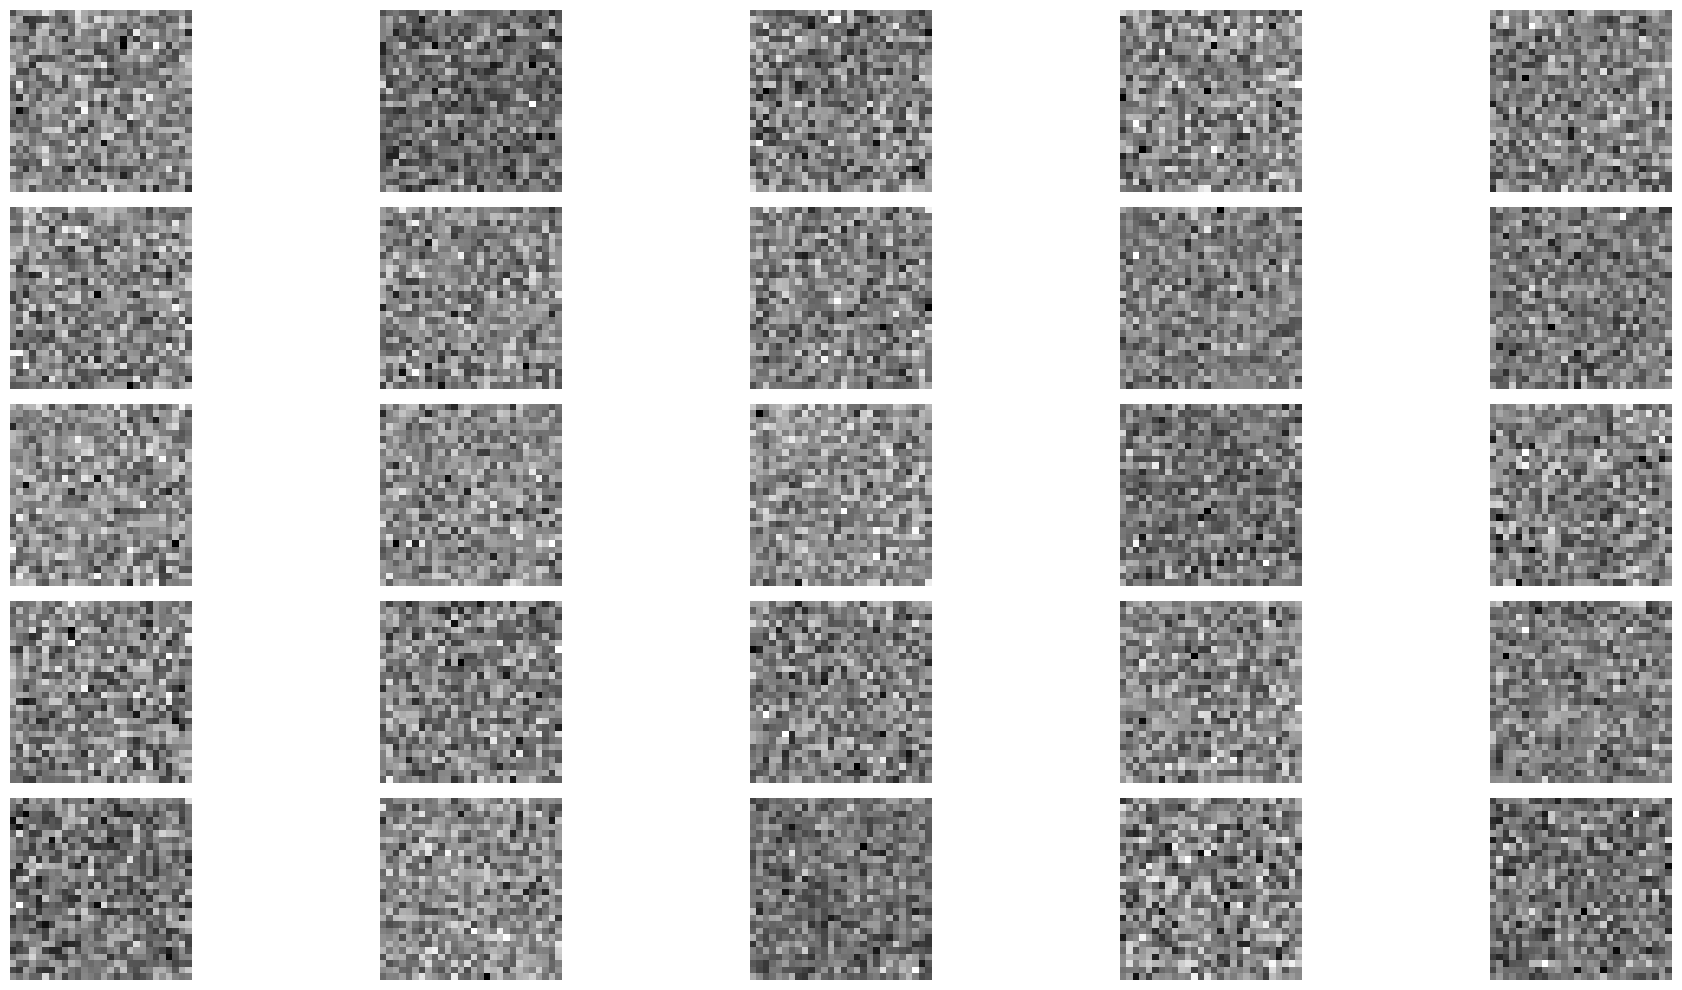

In [3]:
fig, ax = plt.subplots(5,5, figsize=(20,10))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(tasks[0][i*5+j].view(28,28).cpu(), cmap='gray')
        ax[i,j].axis('off')

plt.tight_layout()

In [4]:
save_out = False
D = X.shape[1]
P = len(X)

for regime in ['mup']:
    for N in widths:
        
        h = torch.empty((n_tasks+1,(n_tasks+1)*epochs, N, P))
        z = torch.empty((1,(n_tasks+1)*epochs, N))
        loss = torch.empty((n_tasks+1, (n_tasks+1)*epochs))

        acc = []    
        
        mlp = MLP(N,L,regime, gamma0)
        lrs = {'sp':1,'ntk':1,'mup': eta*mlp.gamma**2}
        lr = lrs.get(regime)

        if regime == 'ntk' or regime == 'mup':
            mlp = mlp.apply(init_weights)
            
        #summary(mlp, (1,784))
        mlp = mlp.to(device)
        
        optimizer = torch.optim.SGD(mlp.parameters(), lr= lr )
        eos = 2/lr
     
        MSE = nn.MSELoss()

        for t,Xt in enumerate(tasks):        
                for epoch in range(epochs):
                            if epoch==0 and t==0:
                                out, _ , _ = mlp(Xt)
                                out_at_0 = out.detach().clone()

                            running_loss = 0.0
                            
                            for n,X in enumerate(tasks):
                                out, ht, zt = mlp(X)
                                h[n,t*epochs+epoch] = ht.T
                                z[0,t*epochs+epoch] = zt.T
                                loss[n,t*epochs+epoch] = MSE(out,Y)*0.5
                            
                            optimizer.zero_grad()

                            out, _ , _ = mlp(Xt)
                            losscurr = MSE(out-out_at_0, Y)*0.5
                           
                            losscurr.backward()
                           
                            running_loss += losscurr.item()
                            
                            optimizer.step()

                print(f'Finished Training task{t}, train loss: {running_loss/batch}')
                
                acct = []
                for s in range(t+1):
                    acct.append( (torch.sum(torch.round(mlp(tasks_test[s])[0]) == Y_test)/len(Y_test)).item() )  
                acc.append(acct) 
        
        if save_out:   
            torch.save(loss, f'loss_data/loss{N}_gamma{gamma0}.pt')

/var/folders/bf/nxgsxk9n0xvdy1w25bwdrpg80000gn/T/ipykernel_68621/2997082458.py:40: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3639.)
  z[0,t*epochs+epoch] = zt.T


Finished Training task0, train loss: 2.177037276851479e-07
Finished Training task1, train loss: 2.0691325985922048e-10
Finished Training task2, train loss: 1.6672633273984162e-11
Finished Training task3, train loss: 5.049856088845672e-12


In [5]:
mlp = mlp.eval()

In [ ]:
print((torch.sum(torch.round(mlp(X_test)[0]) == Y_test)/len(Y_test)).item())

In [ ]:
(torch.sum(torch.round(mlp(tasks_test[1])[0]) == Y_test)/len(Y_test)).item()

In [8]:
D = X.shape[1]
N = widths[-1]
P = len(X)

In [ ]:
X_tot = tasks[0]
for i in range(n_tasks):
    X_tot = torch.vstack((X_tot, tasks[i+1]))
    
K_tot = X_tot @ X_tot.T / D

Ks = torch.empty((n_tasks+1, n_tasks+1, P, P))
for i in range(n_tasks+1):
    for j in range(n_tasks+1):
       Ks[i,j] = tasks[i] @ tasks[j].T / D

plt.imshow(K_tot.cpu(), cmap='coolwarm')
plt.colorbar()
plt.show()

In [ ]:
(K_tot.T - K_tot).sum()

In [ ]:
fig, ax = plt.subplots(n_tasks+1,n_tasks+1, figsize = (8,8))
for i in range(n_tasks+1):
    for j in range(n_tasks+1):
        a = ax[i,j].imshow(Ks[i,j], cmap='coolwarm', vmin=0, vmax=1)
        ax[i,j].axis('off')
        if j == n_tasks:
            plt.colorbar(a, ax = ax[i,j], fraction=0.05)
        
for i in range(n_tasks+1):
    ax[0,i].set_title(f'$\mathcal{{T}}_{{{i+1}}}$', fontsize=16)

for j in range(n_tasks+1):
    fig.text(0.002, (n_tasks+1-j)/(n_tasks+1) - 1/(n_tasks+1)**2, f'$\mathcal{{T}}_{{{j+1}}}$', va='center', ha='center', fontsize=16, rotation='vertical')

plt.tight_layout()

# Simulation

In [12]:
S = 10000

hs = torch.empty((n_tasks+1,(n_tasks+1)*epochs, S, P))
zs = torch.empty((1,(n_tasks+1)*epochs, S))
deltas = torch.empty((n_tasks+1,(n_tasks+1)*epochs, P))

zs[0,0] = sampleXi(S)
chi_tot = sampleChi( K_tot.cpu(), (n_tasks+1)*P, S)

for t in range(n_tasks+1):
    hs[t,0] = chi_tot[::,P*t:P*(t+1)]
    deltas[t,0] = torch.sum(Y, dim=1).cpu()

for c in range(n_tasks+1):
    for i in np.arange(c*epochs-1,(c+1)*epochs-1,1):
        for t in range(n_tasks+1):
            if i == -1: continue
            
            h_up, z_up = Update( deltas[c,i] , zs[0,i], hs[t,i], zs[0,i], hs[c,i], Ks[t,c], gamma0, eta, relu=relu)
            hs[t,i+1] = h_up
            zs[0,i+1] = z_up

            delta_up = updateDelta( hs[t,i], hs[c,i], zs[0,i], Ks[t,c], deltas[t,i], deltas[c,i], eta )
            deltas[t,i+1] = delta_up

In [ ]:
fig, ax = plt.subplots(n_tasks+1,n_tasks+1, figsize = (8,8) )
fig.suptitle('All $\Phi$ kernels', fontsize=16)

#vmin_th = float('inf')
#vmax_th = float('-inf')
#
#for i in range(n_tasks+1):
#    for j in range(n_tasks+1):
#        phi = get_Phi(h[i,-1],h[j,-1],relu)
#        #matrix = get_Phi(hs[0,max(0,i*epochs-1)],hs[1,max(0,i*epochs-1)], relu)
#        vmin_th = min(vmin_th, phi.min())
#        vmax_th = max(vmax_th, phi.max())
        
for i in range(n_tasks+1):
    for j in range(n_tasks+1):
        phi = get_Phi(hs[i,300],hs[j,300],relu)
        a = ax[i,j].imshow(phi, cmap='coolwarm')
        ax[i,j].axis('off')
        #plt.colorbar(a, ax=ax[i,j])
        
for i in range(n_tasks+1):
    ax[0,i].set_title(f'$\mathcal{{T}}_{{{i+1}}}$', fontsize=16)

for j in range(n_tasks+1):
    fig.text(0.002, (n_tasks+1-j)/(n_tasks+1) - 1/(n_tasks+1)**2, f'$\mathcal{{T}}_{{{j+1}}}$', va='center', ha='center', fontsize=16, rotation='vertical')

plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(n_tasks+1,n_tasks+1, figsize = (8,8))

for i in range(n_tasks+1):
    for j in range(n_tasks+1):
        g = get_G(z[0,300],h[i,300],h[j,300], relu)
        ax[i,j].imshow(g, cmap='coolwarm')
        ax[i,j].axis('off')
        
for i in range(n_tasks+1):
    ax[0,i].set_title(f'$\mathcal{{T}}_{{{i+1}}}$', fontsize=16)

for j in range(n_tasks+1):
    fig.text(0.002, (n_tasks+1-j)/(n_tasks+1) - 1/(n_tasks+1)**2, f'$\mathcal{{T}}_{{{j+1}}}$', va='center', ha='center', fontsize=16, rotation='vertical')

plt.tight_layout()

In [ ]:
plotKernel(0,1,2*epochs-1)

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(18,10))

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        
        counts, bins = torch.histogram(hs[i*3+j,0], bins=200)
        ax[i,j].plot(bins[:-1], counts/(torch.sum(counts)*(bins[1]-bins[0])), 
                 linestyle = ':', color='black', label = 'Th', linewidth=3)
        
        counts, bins = torch.histogram(h[i*3+j,0], bins=200)
        ax[i,j].plot(bins[:-1], counts/(torch.sum(counts)*(bins[1]-bins[0])), 
                 linestyle = (5, (10, 3)), alpha=0.9, color=colors[i*3+j])
        
        
        counts, bins = torch.histogram(hs[i*3+j,-1], bins=200)
        ax[i,j].plot(bins[:-1], counts/(torch.sum(counts)*(bins[1]-bins[0])), 
                 linestyle = '-.', color='black', )
        
        counts, bins = torch.histogram(h[i*3+j,-1], bins=200)
        ax[i,j].plot(bins[:-1], counts/(torch.sum(counts)*(bins[1]-bins[0])), 
                 color=colors[i*3+j], alpha=0.9, linewidth=3, label = 'Exp')


        ax[i,j].set_yscale('log')
        ax[i,j].tick_params(labelsize=25)
        ax[i,j].set_xlabel('$h$', fontsize=25)
        if j==0:
            ax[i,j].set_ylabel('$p(h)$',fontsize=28)
        ax[i,j].grid()
        ax[i,j].legend(loc='best', prop={'size':18}, title=f'$\mathcal{{T}}_{{{i*3+j+1}}}$', title_fontproperties={'size':21}) 
        
plt.tight_layout()       
plt.show()


In [ ]:
row_titles = ['Theory $\Phi$', 'Exp. $\Phi$' ]

vmin_th = float('inf')
vmax_th = float('-inf')

for j in range(2):
    for i in range(n_tasks+1):
        matrix = get_Phi(hs[0,max(0,i*epochs-1)],hs[1,max(0,i*epochs-1)], relu)
        vmin_th = min(vmin_th, matrix.min())
        vmax_th = max(vmax_th, matrix.max())
           
fig, ax = plt.subplots(2,n_tasks+1, figsize=(20,10))
for j in range(2):
    for i in range(n_tasks+1):
        if j == 0:
                a = ax[j,i].imshow(get_Phi(hs[0,max(0,i*epochs-1)],hs[1,max(0,i*epochs-1)], relu), 
                                   cmap='coolwarm', vmin=vmin_th, vmax=vmax_th)
                ax[j,i].set_title(f'$t=t_{{{i}}}$', fontsize=26, pad=16)
                ax[j,i].axis('off')
            
        else:
                a = ax[j,i].imshow(get_Phi(hs[0,max(0,i*epochs-1)],hs[1,max(0,i*epochs-1)], relu),
                                   cmap='coolwarm', vmin=vmin_th, vmax=vmax_th)
                ax[j,i].axis('off')
                   
for j, row_title in enumerate(row_titles):
        fig.text(0, (2-j*0.7)/2.0 - 1/3.1, row_title, va='center', ha='center', fontsize=28, rotation='vertical')

plt.tight_layout(rect=[0.01, 0.05, 0.9, 0.95])
plt.show()

print(vmin_th)
print(vmax_th)

In [ ]:
row_titles = ['Theory $G$', 'Exp. $G$' ]

vmin_th = float('inf')
vmax_th = float('-inf')

for j in range(2):
    for i in range(n_tasks+1):
        matrix = get_G(z[0,max(0,i*epochs-1)],h[0,max(0,i*epochs-1)],h[1,max(0,i*epochs-1)], relu)
        vmin_th = min(vmin_th, matrix.min())
        vmax_th = max(vmax_th, matrix.max())
           
fig, ax = plt.subplots(2,n_tasks+1, figsize=(20,10))
for j in range(2):
    for i in range(n_tasks+1):
        if j == 0:
                a = ax[j,i].imshow(get_G(z[0,max(0,i*epochs-1)],h[0,max(0,i*epochs-1)],h[1,max(0,i*epochs-1)], relu),
                                   cmap='coolwarm', vmin=vmin_th, vmax=vmax_th)
                ax[j,i].set_title(f'$t=t_{{{i}}}$', fontsize=22, pad=16)
                ax[j,i].axis('off')
            
        else:
                a = ax[j,i].imshow(get_G(z[0,max(0,i*epochs-1)],h[0,max(0,i*epochs-1)],h[1,max(0,i*epochs-1)], relu),
                                   cmap='coolwarm', vmin=vmin_th, vmax=vmax_th)
                ax[j,i].axis('off')
                   
for j, row_title in enumerate(row_titles):
        fig.text(0, (2-j*0.7)/2.0 - 1/3.3, row_title, va='center', ha='center', fontsize=25, rotation='vertical')

plt.tight_layout(rect=[0.01, 0.05, 0.9, 0.95])
plt.show()

print(vmin_th)
print(vmax_th)

In [ ]:
row_titles = ['Theory $K^{NTK}$', 'Exp. $K^{NTK}$' ]
 
vmin_th = float('inf')
vmax_th = float('-inf')

for j in range(2):
    for i in range(n_tasks+1):
        matrix = get_G(z[0,max(0,i*epochs-1)],h[0,max(0,i*epochs-1)],h[1,max(0,i*epochs-1)],relu) * Ks[0,1] + get_Phi(hs[0,max(0,i*epochs-1)],hs[1,max(0,i*epochs-1)], relu)
        vmin_th = min(vmin_th, matrix.min())
        vmax_th = max(vmax_th, matrix.max())
    
fig, ax = plt.subplots(2,n_tasks+1, figsize=(20,10))
for j in range(2):
    for i in range(n_tasks+1):
        if j == 0:
            ntk = get_G(z[0,max(0,i*epochs-1)],h[0,max(0,i*epochs-1)],h[1,max(0,i*epochs-1)],relu) * Ks[0,1] + get_Phi(hs[0,max(0,i*epochs-1)],hs[1,max(0,i*epochs-1)], relu)
            a = ax[j,i].imshow(ntk, cmap='coolwarm',vmin=vmin_th, vmax=vmax_th )
            ax[j,i].set_title(f'$t=t_{{{i}}}$', fontsize=22, pad=16)
            ax[j,i].axis('off')
            
        else:
            ntk = get_G(z[0,max(0,i*epochs-1)],h[0,max(0,i*epochs-1)],h[1,max(0,i*epochs-1)],relu) * Ks[0,1] + get_Phi(hs[0,max(0,i*epochs-1)],hs[1,max(0,i*epochs-1)], relu)
            a = ax[j,i].imshow(ntk, cmap='coolwarm',vmin=vmin_th, vmax=vmax_th)
            ax[j,i].axis('off')
                   
for j, row_title in enumerate(row_titles):
        fig.text(0, (2-j*0.7)/2.0 - 1/3.1, row_title, va='center', ha='center', fontsize=25, rotation='vertical')

plt.tight_layout(rect=[0.01, 0.05, 0.9, 0.95])
plt.show()

print(vmin_th)
print(vmax_th)

In [ ]:
fig = plt.figure(figsize=(16,10))


counts, bins = torch.histogram(hs[0,0].view(-1), bins=200)
plt.plot(bins[:-1], counts/(torch.sum(counts)*(bins[1]-bins[0])), 
         linestyle = ':', color='black', label = 'Th. $t=t_0$', linewidth=3)

counts, bins = torch.histogram(h[0,0].view(-1), bins=200)
plt.plot(bins[:-1], counts/(torch.sum(counts)*(bins[1]-bins[0])), 
         linestyle = (5, (10, 3)),alpha=0.7, color='purple', label = 'Exp. $t=t_0$', linewidth=2)


counts, bins = torch.histogram(hs[0,-1].view(-1), bins=200)
plt.plot(bins[:-1], counts/(torch.sum(counts)*(bins[1]-bins[0])), 
         linestyle = '-.', color='black', label = 'Th. $t=t_6$', linewidth=2)

counts, bins = torch.histogram(h[0,-1].view(-1), bins=200)
plt.plot(bins[:-1], counts/(torch.sum(counts)*(bins[1]-bins[0])), 
         color='purple', alpha=0.6, label = 'Exp. $t=t_6$', linewidth=3)

plt.yscale('log')
plt.tick_params(labelsize=24)
plt.xlabel('$z$', fontsize=24)
plt.ylabel('$p(z)$',fontsize=24)
plt.grid()
plt.legend(prop={'size':25}) 
        
plt.tight_layout()       
plt.show()

In [ ]:
colors = ['blue', 'darkorange','green','red','purple','brown','pink', 'gray', 'olive', 'cyan' , 'darkgreen']

fig = plt.figure(figsize=(18,8))
for i in range(n_tasks+1):
        #loss = torch.load(f'loss_data/loss{4096}_gamma{gamma0}.pt', weights_only=True)
        plt.plot(loss[i].detach().numpy(), alpha= 1, label=f'Exp. $\mathcal{{T}}_{{{i+1}}}$', color=colors[i])
        plt.plot(torch.mean(deltas[i]**2, axis =1)/2, linestyle=':', color=colors[i], label=f'Th. $\mathcal{{T}}_{{{i+1}}}$', linewidth=3)
        plt.fill_between(np.arange(0,(n_tasks+1)*epochs,1),torch.mean(deltas[i]**2, axis =1)/2-(P/N), torch.mean(deltas[i]**2, axis =1)/2+(P/N), alpha=0.1, color=colors[i])

plt.ylabel('Loss', fontsize=26)
plt.xlabel('Epochs', fontsize=26)
plt.legend(prop={'size': 15})
plt.ylim(-0.01,0.3)
plt.grid()
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

for i in range(n_tasks):
    plt.axvline((i+1)*epochs, alpha=0.7, color='black', linestyle='-.')
plt.show()


In [ ]:
fig = plt.figure(figsize=(15,8))
for i in np.arange(0,n_tasks+1,1):
    plt.plot(torch.mean(hs[i], axis = [1,2]) - torch.mean(h[i].cpu(), axis = [1,2]), label=f'Field Diff {i}')
plt.grid()
plt.legend()
plt.show()

plt.plot(torch.mean(zs[0], axis = [1])-torch.mean(z[0,:], axis = [1]), label='theory')
#plt.plot(torch.mean(z[0,:], axis = [1]), label='exp')
plt.legend()
plt.show()

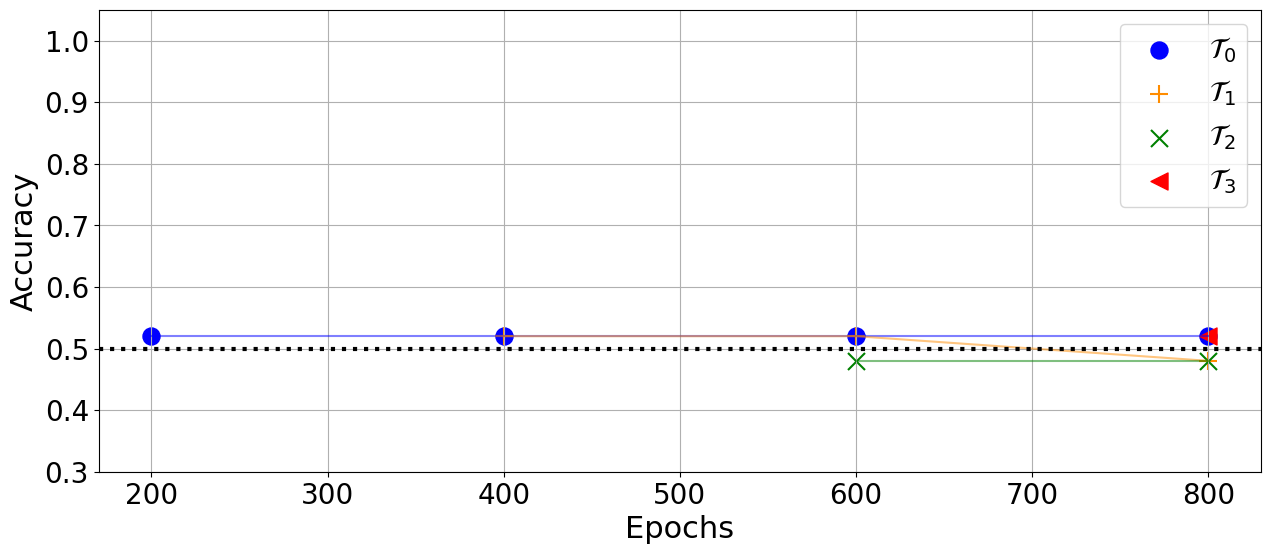

In [132]:
fig = plt.figure(figsize=(15,6))

marks=['o','+','x','<','*','s']

for i in range(n_tasks+1):
        plt.scatter(np.arange(i*epochs+epochs,(n_tasks+1)*epochs+epochs,epochs),[a[i] for a in acc[i:]], color=colors[i], marker=marks[i], 
                  label=f'$\mathcal{{T}}_{{{i}}}$', s=150)
        plt.plot(np.arange(i*epochs+epochs,(n_tasks+1)*epochs+epochs,epochs),[a[i] for a in acc[i:]], color=colors[i],  alpha=0.5)

plt.axhline(0.5,linewidth=3, color='black', linestyle=':')
plt.ylim(0.30,1.05)

plt.grid()
plt.xlabel('Epochs', fontsize=22)
plt.ylabel('Accuracy', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size':20})
plt.show()


In [ ]:
HLT

In [ ]:
from matplotlib.animation import FuncAnimation

# Sample data for hs and h (replace with your actual data)
# Example shape: hs = torch.randn(6, 500), h = torch.randn(6, 500)

# Create figure and subplots
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
colors = ['blue', 'darkorange', 'green', 'red', 'purple', 'brown']

# Function to initialize the plot
def init():
    for i in range(2):
        for j in range(3):
            ax[i, j].clear()
            ax[i, j].set_yscale('log')
            ax[i, j].tick_params(labelsize=25)
            ax[i, j].set_xlabel('$h$', fontsize=25)
            if j == 0:
                ax[i, j].set_ylabel('$p(h)$', fontsize=28)
            ax[i, j].grid()
    return ax

# Function to update the plot for each frame (time step)
def update(t):
    for i in range(2):
        for j in range(3):
            idx = i * 3 + j
            
            # Clear the previous data to update with new time step
            ax[i, j].cla()
            
            # Update Th (current time step t)
            counts_th, bins_th = torch.histogram(hs[idx, t*5], bins=200)
            ax[i, j].plot(bins_th[:-1], counts_th / (torch.sum(counts_th) * (bins_th[1] - bins_th[0])),
                          linestyle=':', color='black', label='Th', linewidth=3)
            
            # Update Exp (current time step t)
            counts_exp, bins_exp = torch.histogram(h[idx, t*5], bins=200)
            ax[i, j].plot(bins_exp[:-1], counts_exp / (torch.sum(counts_exp) * (bins_exp[1] - bins_exp[0])),
                          linestyle=(5, (10, 3)), alpha=0.9, label='Exp', color=colors[idx])

            # Set the axis and grid again
            ax[i, j].set_yscale('log')
            ax[i, j].tick_params(labelsize=25)
            ax[i, j].set_xlabel('$h$', fontsize=25)
            if j == 0:
                ax[i, j].set_ylabel('$p(h)$', fontsize=28)
            ax[i, j].grid()
            
            # Add legend with title
            ax[i, j].legend(loc='best', prop={'size': 18}, 
                            title=f'$\mathcal{{T}}_{{{idx+1}}}$', title_fontproperties={'size': 21})
    
    plt.tight_layout()
    return ax

# Create the animation
T = 240  # The total number of time steps, assumed to be the second dimension of hs and h
anim = FuncAnimation(fig, update, frames=T, init_func=init, blit=False)

# Save the animation as a GIF
anim.save('distribution_animation_gamma_2.gif', writer='imagemagick', fps=10)

# Display the plot (optional)
plt.show()


In [ ]:
# Create figure and subplots
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
colors = ['blue', 'darkorange', 'green', 'red', 'purple', 'brown']

# Function to initialize the plot
def init():
    for i in range(2):
        for j in range(3):
            ax[i, j].clear()
            ax[i, j].set_yscale('log')
            ax[i, j].tick_params(labelsize=25)
            ax[i, j].set_xlabel('$h$', fontsize=25)
            if j == 0:
                ax[i, j].set_ylabel('$p(h)$', fontsize=28)
            ax[i, j].grid()
    return ax

# Function to update the plot for each frame (time step)
def update(t):
    for i in range(2):
        for j in range(3):
            idx = i * 3 + j
            
            # Clear the previous data to update with new time step
            ax[i, j].cla()
            
            # Update Th (current time step t)
            counts_th, bins_th = torch.histogram(hs[idx, t*5], bins=200)
            ax[i, j].plot(bins_th[:-1], counts_th / (torch.sum(counts_th) * (bins_th[1] - bins_th[0
                          linestyle=':', color='black', label='Th', linewidth=3)
            
            # Update Exp (current time step t)
            counts_exp, bins_exp = torch.histogram(h[idx, t*5], bins=200)
            ax[i, j].plot(bins_exp[:-1], counts_exp / (torch.sum(counts_exp) * (bins_exp[1] - bins_
                          linestyle=(5, (10, 3)), alpha=0.9, label='Exp', color=colors[idx])

            # Set the axis and grid again
            ax[i, j].set_yscale('log')
            ax[i, j].tick_params(labelsize=25)
            ax[i, j].set_xlabel('$h$', fontsize=25)
            if j == 0:
                ax[i, j].set_ylabel('$p(h)$', fontsize=28)
            ax[i, j].grid()
            
            # Add legend with title
            ax[i, j].legend(loc='best', prop={'size': 18}, 
                            title=f'$\mathcal{{T}}_{{{idx+1}}}$', title_fontproperties={'size': 21}
    
    plt.tight_layout()
    return ax

# Create the animation
T = 240  # The total number of time steps, assumed to be the second dimension of hs and h
anim = FuncAnimation(fig, update, frames=T, init_func=init, blit=False)

# Save the animation as a GIF
anim.save('kernels_animation.gif', writer='imagemagick', fps=10)

# Display the plot (optional)
plt.show()

In [ ]:
row_titles = ['Theory $\Phi$', 'Exp. $\Phi$' ]

vmin_th = float('inf')
vmax_th = float('-inf')

for j in range(2):
    for i in range(7):
        matrix = get_Phi(hs[0,max(0,i*epochs-1)],hs[1,max(0,i*epochs-1)], relu)
        vmin_th = min(vmin_th, matrix.min())
        vmax_th = max(vmax_th, matrix.max())
           
fig, ax = plt.subplots(2,7, figsize=(20,10))
for j in range(2):
    for i in range(7):
        if j == 0:
                a = ax[j,i].imshow(get_Phi(hs[0,max(0,i*epochs-1)],hs[1,max(0,i*epochs-1)], relu), 
                                   cmap='coolwarm', vmin=vmin_th, vmax=vmax_th)
                ax[j,i].set_title(f'$t=t_{{{i}}}$', fontsize=26, pad=16)
                ax[j,i].axis('off')
            
        else:
                a = ax[j,i].imshow(get_Phi(hs[0,max(0,i*epochs-1)],hs[1,max(0,i*epochs-1)], relu),
                                   cmap='coolwarm', vmin=vmin_th, vmax=vmax_th)
                ax[j,i].axis('off')
                   
for j, row_title in enumerate(row_titles):
        fig.text(0, (2-j*0.7)/2.0 - 1/3.1, row_title, va='center', ha='center', fontsize=28, rotation='vertical')

plt.tight_layout(rect=[0.01, 0.05, 0.9, 0.95])
plt.show()

In [ ]:
alignH = DMFTalignment(hs,hs, h,h, zs, z)
alignG = DMFTalignment(hs,hs, h,h, zs, z, 'g')

torch.save( alignH, f'align_data/alignH{N}_gamma{gamma0}.pt')
torch.save( alignG, f'align_data/alignG{N}_gamma{gamma0}.pt')

In [ ]:
plt.figure(figsize=(16,8))

for i,row in enumerate(alignH):
    plt.plot(row, label=f'TA $\mathcal{{T}}_{{{i+1}}}$', color=colors[i])
    plt.axhline(row[0], linestyle = ':', color = colors[i], linewidth=3)

plt.legend(prop={'size':20})
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Epochs', fontsize=24)
plt.ylabel('$cos(\Theta)$', fontsize=24)
plt.grid()

plt.figure(figsize=(16,8))

for i,row in enumerate(alignG):
    plt.plot(row, label=f'TA $\mathcal{{T}}_{{{i+1}}}$', color=colors[i])
    plt.axhline(row[0], linestyle = ':', color = colors[i], linewidth=3)

plt.legend(prop={'size':20})
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Epochs', fontsize=24)
plt.ylabel('$cos(\Theta)$', fontsize=24)
plt.grid()

In [ ]:
computeCorr(hs,hs,zs,'g')
computeCorr(h,h,z,'g')

In [ ]:
computeCorr(hs,hs,zs,'h')
computeCorr(h,h,z,'h')

In [ ]:
HLT

In [ ]:
ax[i,j].axvline(d*epochs, color='black', alpha=0.85, linestyle=':')
                ax[i,j].axhline(d*epochs, color='black', alpha=0.85, linestyle=':')
                ax[i,j].xaxis.set_tick_params(labelbottom=False)
                ax[i,j].yaxis.set_tick_params(labelbottom=False)
                if i==1:
                    ax[i,j].set_xlabel('Epochs',fontsize=26)
                    ax[i,j].xaxis.set_tick_params(labelbottom=True)
                if j==0:
                    ax[i,j].set_ylabel('Epochs',fontsize=26)
                    ax[i,j].yaxis.set_tick_params(labelbottom=True)
                ax[i,j].tick_params(axis='both', which='major', labelsize=20)

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(15,8))

for i in range(n_tasks+1):
    tot_align = torch.empty((8,1200))
    for j,n in enumerate([32,64,128,256,512,1024,2048,4096]):
        align = torch.load(f'align_data/alignG{n}_gamma{gamma0}.pt', weights_only=True)
        tot_align[j] = align[i]
    a = ax[int(i/3),i%3].imshow(tot_align, cmap='coolwarm', aspect='auto')
    cbar =plt.colorbar(a, ax=ax[int(i/3),i%3])
    cbar.ax.tick_params(labelsize=18) 
    
    ax[int(i/3),i%3].set_title(f'$\mathcal{{T}}_{{{i+1}}}$', fontsize=24)
    
    ax[0,i%3].xaxis.set_tick_params(labelbottom=False)
    
    ax[int(i/3),0].set_yticklabels([0,32,128,512,2048])
    
    ax[int(i/3),1].yaxis.set_tick_params(labelbottom=False)
    ax[int(i/3),2].yaxis.set_tick_params(labelbottom=False)
    
    ax[int(i/3),i%3].tick_params(axis='both', which='major', labelsize=16)
    ax[1,i%3].set_xlabel('Epochs', fontsize=22)
    ax[int(i/3),0].set_ylabel('Width', fontsize=22)
    
    for c in range(n_tasks):
        ax[int(i/3),i%3].axvline((c+1)*epochs, color='black', linestyle=':')
    
    
    
plt.tight_layout()

In [ ]:
var_forg = 0
for i in np.arange(1, n_tasks+1, 1):
    forg1 = ForgMeasure(hs,hs,zs, var_forg, i)
    forg2 = ForgMeasure(h,h,z, var_forg, i)

In [ ]:
fig, ax = plt.subplots(2,1 ,figsize=(20,12))

for i in np.arange(1, n_tasks+1, 1):
    ax[0].plot(np.arange(i*epochs, (i+1)*epochs, 1), forg1[i*epochs:(i+1)*epochs], color=colors[i], linestyle=':')
    ax[0].plot(np.arange(i*epochs, (i+1)*epochs, 1), forg2[i*epochs:(i+1)*epochs], color=colors[i], label =f'Task $T_{i+1}$')
    ax[0].axvline(i*epochs, linestyle='-.', color='black')
    ax[1].axvline(i*epochs, linestyle='-.', color='black')
    

ax[1].plot(loss[0].detach().clone(), alpha=0.5, color='blue', )
ax[0].set_title('Orthogonal measure of NTK across tasks $T_1$ for each training tasks', fontsize=18)
ax[1].set_title('Loss of task $T_1$', fontsize=18)
ax[0].legend(prop={'size':12})
ax[0].set_xlim(-50,1250)
ax[1].set_xlim(-50,1250)
plt.show()

In [ ]:
HLT

In [ ]:
from kmeans_pytorch import kmeans, kmeans_predict

In [ ]:
space = 100
feat_scoret = torch.empty((n_tasks+1,space))
feat_scoree = torch.empty((n_tasks+1,space))

for t in range(n_tasks+1): 
    for j in range(space):
        
        cluster_ids_x, cluster_centers = kmeans( X=h[t,int(n_tasks*epochs/space*j)].T, num_clusters=2, distance='euclidean', device=device)
    
        if cluster_ids_x[0].item() == 1:
            feat_scoree[t,j] = torch.sum(((cluster_ids_x-1)*-1 - Y.view(-1).cpu())**2)/2
        else:
            feat_scoree[t,j] = torch.sum((cluster_ids_x - Y.view(-1).cpu())**2)/2

for t in range(n_tasks+1): 
    for j in range(space):
        
        cluster_ids_x, cluster_centers = kmeans( X=hs[t,int(n_tasks*epochs/space*j)].T, num_clusters=2, distance='euclidean', device=device)
    
        if cluster_ids_x[0].item() == 1:
            feat_scoret[t,j] = torch.sum(((cluster_ids_x-1)*-1 - Y.view(-1).cpu())**2)/2
        else:
            feat_scoret[t,j] = torch.sum((cluster_ids_x - Y.view(-1).cpu())**2)/2

In [ ]:
ax[i,j].xaxis.set_tick_params(labelbottom=False)
                ax[i,j].yaxis.set_tick_params(labelbottom=False)
                if i==1:
                    ax[i,j].set_xlabel('Epochs',fontsize=26)
                    ax[i,j].xaxis.set_tick_params(labelbottom=True)
                if j==0:
                    ax[i,j].set_ylabel('Epochs',fontsize=26)
                    ax[i,j].yaxis.set_tick_params(labelbottom=True)

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(20,12))

for t in range(n_tasks+1):
    ax[int(t/3),t%3].scatter(np.linspace(0,epochs*(n_tasks+1),space),feat_scoree[t]/P, color = 'blue', alpha = 0.5, 
                          label = 'Exp.', marker='o', linestyle='-.', s=90)
    ax[int(t/3),t%3].scatter(np.linspace(0,epochs*(n_tasks+1),space),feat_scoret[t]/P, color = 'red', alpha = 0.5, 
                          label = 'Theory',marker='o', linestyle='-.', s=90)
    
    ax[int(t/3),t%3].axvline((t+1)*epochs, color='black', linestyle=':',linewidth=3)
    ax[int(t/3),t%3].legend(prop={'size':22})
    
    ax[int(t/3),t%3].axvline((t)*epochs, color='black', linestyle=':', linewidth=3)
    ax[int(t/3),t%3].set_title(f'$\mathcal{{T}}_{{{t+1}}}$', fontsize=24)
    
    ax[int(t/3),t%3].set_ylim(-0.05,0.35)
    ax[1,t%3].set_xlabel('Epochs', fontsize=26)
    ax[int(t/3),0].set_ylabel('Loss', fontsize=26)
    ax[int(t/3),t%3].tick_params(labelsize=22)
    ax[0,t%3].xaxis.set_tick_params(labelbottom=False)
    ax[int(t/3),1].yaxis.set_tick_params(labelbottom=False)
    ax[int(t/3),2].yaxis.set_tick_params(labelbottom=False)
    ax[int(t/3),t%3].axhline(0, color='black', linestyle='-.', linewidth=2)
    ax[int(t/3),t%3].grid()
    
plt.tight_layout()

In [ ]:
ws = [8,16,32,64,128,256,512,1024]

align = torch.empty(len(ws),6,1200)

fig, ax = plt.subplots(2,3, figsize=(20,10))

for i,N in enumerate(ws):
    align[i] = torch.load(f'loss_data/align{N}_3')
   
vmin = torch.min(align)
vmax = torch.max(align)

for i in range(n_tasks+1):
    axs = ax[int(i/3),i%3].imshow(align[:,i], cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
    ax[int(i/3),i%3].set_yticks(np.arange(0,len(ws),1),ws)
    ax[int(i/3),i%3].set_ylabel('Widths')
    ax[int(i/3),i%3].set_xlabel('Epochs')
    for j in range(n_tasks+1):
        ax[int(i/3),i%3].axvline(epochs*j, color='black', linestyle='-.', alpha = 0.4)
        
    ax[int(i/3),i%3].set_title(f'Alignment theory-exp task {i+1}')
    plt.colorbar(axs, ax=ax[int(i/3),i%3])
    
    
plt.tight_layout()
plt.show()

In [ ]:
colors = ['blue', 'orange','green','red','purple','brown','pink', 'gray', 'olive', 'cyan' , 'darkgreen']

fig = plt.figure(figsize=(20,12))
for j,N in enumerate(widths):
    for i in [0,1,4,5]:
        loss = torch.load(f'loss_data/loss{N}_gamma{gamma0}.pt', weights_only=True)
        if N == 4096:
            plt.plot(loss[i].detach().numpy(), label=f'Exp. $\mathcal{{T}}_{{{i+1}}}$', color=colors[i], linewidth=j+1)
            plt.plot(torch.mean(deltas[i]**2, axis =1)/2, linestyle=':', color=colors[i], label=f'Theor. $\mathcal{{T}}_{{{i+1}}}$')
        else:
            plt.plot(loss[i].detach().numpy(), color=colors[i], linewidth=j+1)
            plt.plot(torch.mean(deltas[i]**2, axis =1)/2, linestyle=':', color=colors[i])
        #plt.fill_between(np.arange(0,(n_tasks+1)*epochs,1),torch.mean(deltas[i]**2, axis =1)/2-(P/N), torch.mean(deltas[i]**2, axis =1)/2+(P/N), alpha=0.06, color=colors[i])

plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.legend(prop={'size': 17})
plt.ylim(0,0.3)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for i in range(n_tasks):
    plt.axvline((i+1)*epochs, alpha=0.7, color='black', linestyle='-.')
plt.show()


In [ ]:
HLT

(torch.stack([zs[0,0]] * len(X), dim=1)*hs[i*3+j,0]).view(-1)

In [ ]:
!tar chvfz DMFTserial.tar.gz datatot loss_data DMFT.ipynb MUP.ipynb NTK2.ipynb